# Phase field method with Fenics

Code from https://github.com/Hirshikesh/FEniCS-PhaseField-brittle-fracture/blob/master/TensionTest/Tension.py

In [1]:
import os
os.environ['PKG_CONFIG_PATH'] = '/home/miele/miniconda3/envs/fenics/lib/pkgconfig'

from dolfin import *
import matplotlib.pyplot as plt
#from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

set_log_active(False)

## Define and refine mesh

In [2]:
nx = 1
ny = 1
num = 1
mesh = Mesh()
editor = MeshEditor()
editor.open(mesh, 'triangle', 2, 2)
editor.init_vertices(10)
editor.init_cells(8)
editor.add_vertex(0, Point(0, 0.0))
editor.add_vertex(1, Point(0.5, 0.0))
editor.add_vertex(2, Point(0.5, 0.5))
editor.add_vertex(3, Point(0.0, 0.5))
editor.add_vertex(4, Point(-0.5, 0.5))
editor.add_vertex(5, Point(-0.5, 0.0))
editor.add_vertex(6, Point(-0.5, -0.5))
editor.add_vertex(7, Point(0.0, -0.5))
editor.add_vertex(8, Point(0.5, -0.5))
editor.add_vertex(9, Point(-0.5, 0.0))
editor.add_cell(0, (0, 1, 3))
editor.add_cell(1, (1, 2, 3))
editor.add_cell(2, (0, 3, 4))
editor.add_cell(3, (0, 4, 5))
editor.add_cell(4, (0, 9, 7))
editor.add_cell(5, (6, 7, 9))
editor.add_cell(6, (0, 7, 8))
editor.add_cell(7, (0, 8, 1))
editor.close()


num_refine = 4
h=0.5**num_refine
for i in range(num_refine):
   mesh=refine(mesh)
print("number of unknowns",mesh.num_vertices())
print("number of elements",mesh.num_cells())

number of unknowns 1105
number of elements 2048


### Plot the mesh

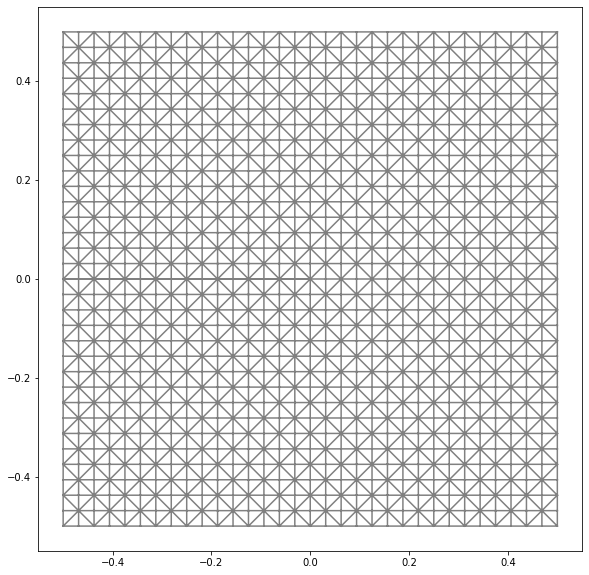

In [3]:
plot(mesh)

fig = plt.gcf()
fig.set_size_inches(10, 10) 

## Get nodes at the top boundary for Reaction force calculations

In [4]:
def num_nem(seq, idfun=None): 
   # order preserving
   if idfun is None:
       def idfun(x): return x
   seen = {}
   result = []
   for item in seq:
       marker = idfun(item)
       if marker in seen: continue
       seen[marker] = 1
       result.append(item)
   return result

class TopBoundary(SubDomain):
        def inside(self, x, on_boundary):
                tol = 1E-14
                return on_boundary and near(x[1], 0.5, tol)

topBoundary = TopBoundary()
ff = MeshFunction('size_t',mesh, mesh.topology().dim()-1)
topBoundary.mark(ff,1)

It_mesh = SubsetIterator(ff, 1) #(a, b) are all points on the top boundary
a = []
b = []
for c in It_mesh:
     for v in vertices(c):
         a.append(v.midpoint().x())
         b.append(v.midpoint().y())

dd = num_nem(a)
da = num_nem(b)

#------------------
# verify that we have found the top boundary
#------------------

# plot(mesh)
# plt.scatter(a, b, color='green')
# fig = plt.gcf()
# fig.set_size_inches(10, 10) 

## Define function spaces, trial functions

In [5]:
V = FunctionSpace(mesh,'CG',1)
W = VectorFunctionSpace(mesh,'CG',1)

p , q = TrialFunction(V), TestFunction(V)
u , v = TrialFunction(W), TestFunction(W)

#------------------------------------------------
#           Parameters
#------------------------------------------------

l_fac = 2
Gc =  2.7
hm = mesh.hmin()
print('hm = ', hm)
l_o = l_fac*hm
print('l_o = ', l_o)

lmbda = 121.15e3
mu = 80.77e3

hm =  0.04419417382415922
l_o =  0.08838834764831845


## Stress, strain, energy density (?), boundary conditions

In [6]:
def epsilon(u): #strain
    return sym(grad(u))
def sigma(u): #stress
    return 2.0*mu*epsilon(u) + lmbda*tr(epsilon(u))*Identity(2)
def en_dens(u): #probably energy density?
    str_ele = 0.5*(grad(u) + grad(u).T) 
    IC = tr(str_ele)
    ICC = tr(str_ele * str_ele)
    return (0.5*lmbda*IC**2) + mu*ICC

#---------------------------
# Boundary conditions
#---------------------------

class top(SubDomain):
    def inside(self,x,on_boundary):
        tol = 1e-10
        return abs(x[1]-0.5) < tol and on_boundary

class bottom(SubDomain):
    def inside(self,x,on_boundary):
        tol = 1e-10
        return abs(x[1]+0.5) < tol and on_boundary
class Middle(SubDomain): 
    def inside(self,x,on_boundary):
        tol = 1e-3
        return abs(x[1]) < tol and x[0] <= 0.0

middle = Middle()    
Top = top()
Bottom = bottom()
u_Lx = Expression("t",t = 0.0, degree = 2)
bclx= DirichletBC(W.sub(0), Constant(0.0), Bottom) #bclx = boundary condition lower x (no slip)
bcly = DirichletBC(W.sub(1), Constant(0.0), Bottom) #boundary condition lower y (no slip)


#-------------------------------------------------------
# Change this boundary condition to get a shear test?
#-------------------------------------------------------
bcty = DirichletBC(W.sub(1), u_Lx, Top) #boundary condition top y (seems to update in loop below)

bc_u = [bcly,bclx,bcty]

bc_phi = [DirichletBC(V,Constant(1.0),middle)]

## Define variational form

In [7]:
uold, unew, uconv = Function(W), Function(W), Function(W)
phiold, phiconv = Function(V), Function(V)
E_du =  ( pow((1-phiold),2) + 1e-6)*inner(grad(v), sigma(u))*dx
E_phi = ( Gc*l_o*inner(grad(p),grad(q))+\
            ((Gc/l_o) + 2.0*en_dens(unew))*inner(p,q)-\
            2.0*en_dens(unew)*q)*dx
u = Function(W)
p = Function(V)
p_disp = LinearVariationalProblem(lhs(E_du),rhs(E_du),u,bc_u)
p_phi = LinearVariationalProblem(lhs(E_phi),rhs(E_phi),p, bc_phi)

solver_disp = LinearVariationalSolver(p_disp)
solver_phi = LinearVariationalSolver(p_phi)
#t = 1e-5
t = 1e-3
max_load = 0.03
#deltaT  = 1e-5
deltaT = 1e-3
ut = 1

## Reference data (??) and solution step

In [8]:
# -----------------------------------------
# Data from Ref: Ambati et. al.
#------------------------------------------
re = np.matrix([[0.000010050251256281352, 0.0035087719298245723],
                [0.00033165829145728634, 0.04561403508771933],
                [0.0006834170854271358, 0.09473684210526312],
                [0.0010653266331658293, 0.14385964912280702],
                [0.0014371859296482413, 0.19122807017543852],
                [0.0017989949748743721, 0.243859649122807],
                [0.002331658291457287, 0.31052631578947365],
                [0.0028040201005025134, 0.37368421052631573],
                [0.003206030150753769, 0.42280701754385963],
                [0.003748743718592965, 0.4929824561403508],
                [0.004271356783919599, 0.5596491228070175],
                [0.004763819095477387, 0.6157894736842104],
                [0.005175879396984925, 0.6649122807017542],
                [0.005396984924623116, 0.687719298245614],
                [0.005457286432160805, 0.5982456140350876],
                [0.0055175879396984935, 0.44385964912280695],
                [0.005557788944723619, 0.26140350877192986],
                [0.005587939698492464, 0.14912280701754388],
                [0.005587939698492464, 0.05087719298245619],
                [0.005587939698492464, 0.0035087719298245723],
                [0.005979899497487438, 0.0052631578947369695],
                ])

x = re[:,0]
y = re[:,1]
#ax = plt.subplot(111)
#plt.plot(x,y,'ro', label='Reference Data')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#          ncol=3, fancybox=True, shadow=True)
#plt.hold(True)

f = open('Tension.txt', 'a')
while t<= max_load:
    if t >=5e-3:
        #deltaT = 1e-5
        deltaT = 1e-3
    u_Lx.t=t*ut
    uold.assign(uconv)
    phiold.assign(phiconv)
    iter = 1
    toll = 1e-2
    err = 1

    while err > toll:
        solver_disp.solve()
        unew.assign(u)
        solver_phi.solve()

        err_u = errornorm(u,uold, norm_type = 'l2', mesh = None)/norm(u)
        err_phi = errornorm(p,phiold, norm_type = 'l2', mesh = None)/norm(p)
        err = max(err_u, err_phi)
        #print('iter', iter,'error', err)
        uold.assign(u)
        phiold.assign(p)
        iter = iter+1
        if err < toll:
            uconv.assign(u)
            phiconv.assign(p)
            #print('solution converges after:', iter)
 
            ux,uy = split(u)
            #plot(ux,key = 'ux',title = 'u_dispx')
            #plot(uy,key ='uy',title = 'u_dispy')
            #plot(p,range_min = 0.,range_max = 1.,key = 'phi',title = 'phi%.4f'%(t))
            
            # calculate reaction force
            k_matx=assemble(E_du)
            u_vec=u.vector()
            F_vec=k_matx*u_vec
            Ft_func=Function(W,F_vec)
            f_allY=[]
            for k in dd:
                fy=Ft_func(k,0.5)
                #print fy
                fyt=fy[1]
                #print fyt
                f_allY.append(fyt)
                #print f_allY
                f_allY_s=f_allY
                #print f_allY
                #f_y_u.append(f_allY_s)
            b=sum(f_allY_s)
            #print(b)
            #plt.scatter(t,(b*1e-3))
            #plt.pause(0.05)
            a = [(t,b*1e-3)]
            np.savetxt(f,a)
            

            
  
    t+=deltaT
    print('simulation is', int(100*t/max_load), '% complete')
            

print('Simulation Done with no error :)')

simulation is 6 % complete
simulation is 10 % complete
simulation is 13 % complete
simulation is 16 % complete
simulation is 20 % complete
simulation is 23 % complete
simulation is 26 % complete
simulation is 30 % complete
simulation is 33 % complete
simulation is 36 % complete
simulation is 40 % complete
simulation is 43 % complete
simulation is 46 % complete
simulation is 50 % complete
simulation is 53 % complete
simulation is 56 % complete
simulation is 60 % complete
simulation is 63 % complete
simulation is 66 % complete
simulation is 70 % complete
simulation is 73 % complete
simulation is 76 % complete
simulation is 80 % complete
simulation is 83 % complete
simulation is 86 % complete
simulation is 90 % complete
simulation is 93 % complete
simulation is 96 % complete
simulation is 100 % complete
Simulation Done with no error :)


## Plotting

/home/miele/miniconda3/envs/fenics/lib/python3.11/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'key'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


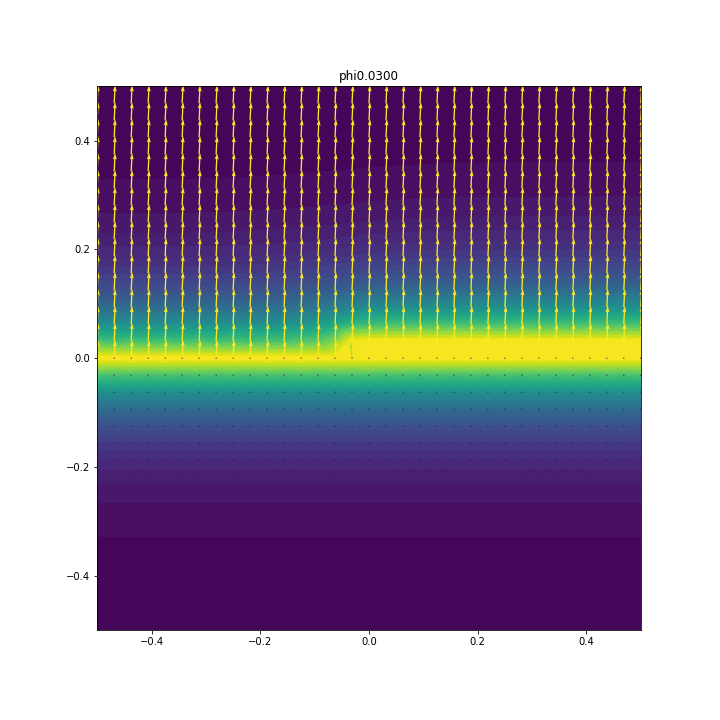

In [9]:
filename = 'fracture_test.png'
directory = '/home/miele/python_scripts/figures/'
#x = re[:,0]
#y = re[:,1]
ax = plt.subplot(111)
#plt.plot(x,y,'ro', label='Reference Data')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#          ncol=3, fancybox=True, shadow=True)

#plot(ux,key = 'ux',title = 'u_dispx')
#plot(uy,key ='uy',title = 'u_dispy')
plot(p,range_min = 0.,range_max = 1.,key = 'phi',title = 'phi%.4f'%(t))
plot(u)
#plot(mesh)


fig = plt.gcf()
fig.set_size_inches(10, 10) 
# Save the figure as an image in the specified directory
plt.savefig(directory + filename)
plt.close()

# Display the saved image
display(Image(directory + filename))

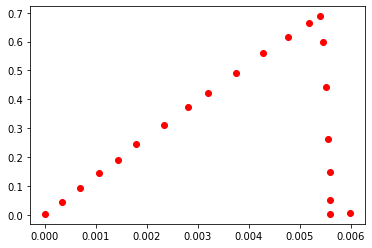

In [10]:
x = re[:,0]
y = re[:,1]
ax = plt.subplot(111)
plt.plot(x,y,'ro', label='Reference Data')
plt.show()